In [ ]:
# use a larger radius to get a larger graph, extract info from outside nodes
# cut step by step, to the center
# cut from the center of this graph, pool from the smaller graph

In [ ]:
# x being patch image itself and x being embedding from cnn
# make a class weight for each of the gene
Data(x=X,y=y,....,mask=mask
    )

mask=[2 2 2 2 2 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 ]
# 2 is most central
z=graph_conv(x)
z=graph_conv2(z)
z,batch,mask=z[mask>0],batch[mask>0],mask[mask>0]
edge_index, _ = subgraph(mask>0,edge_index, return_edge_mask=False)

z=graph_conv3(z)
z=graph_conv4(z)
z,batch=z[mask>1],batch[mask>1]
edge_index, _ = subgraph(mask>1,edge_index, return_edge_mask=False)

z=pool(z,edge_index,batch)


y_pred_aeh_1,y_pred_aeh_2,y_pred_aeh_3,...=fc_aeh_1(z),fc_aeh_2(z),...
# or 
y_pred=fc(z)
# or
y_pred_pathway_1,y_pred_pathway_2,...=... # ask zarif
# see sparselinear layers

In [1]:
import pickle
import os
import numpy as np
import geovoronoi
import shapely
import matplotlib.pyplot as plt
import pandas as pd
import collections
from collections import defaultdict

import torch

from DataManager import dataManager
from graphgen import neighborFinder

from visualize_2 import plotHeatmaps, plotAUROC
import PIL
from tqdm import tqdm, trange

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [2]:
def load_cell_data():
    store = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/store'
   
    with open(f"{store}/xcoords.pickle", "rb") as f:
        xcoords = pickle.load(f)

    with open(f"{store}/ycoords.pickle", "rb") as f:
        ycoords = pickle.load(f)

    with open(f"{store}/patchxy.pickle", 'rb') as f:
        patch_xy = pickle.load(f)
        
    with open(f"{store}/cnn_embed.pickle", "rb") as f:
        embeddings = pickle.load(f)

    slide_cell_locations_all = {}
    slide_embeddings_all = {}
    for slide in ['A1', 'B1', 'C1', 'D1']:
        cell_x = []
        cell_y = []
        embeddings_ = []
        
        xy_set = set()

        cell_counter = 0
        for patch_i, (patch_x, patch_y) in enumerate(patch_xy[slide]):
            for cell_i in range(len(xcoords[slide][patch_i])):
                x = xcoords[slide][patch_i][cell_i] + patch_x
                y = ycoords[slide][patch_i][cell_i] + patch_y
                
                embedding = embeddings[slide][cell_counter]
                
                cell_counter += 1
                
                # Remove duplicates, which does happen sometimes
                if (x, y) in xy_set:
                    continue
                    
                xy_set.add((x, y))

                cell_x.append(x)
                cell_y.append(y)
                embeddings_.append(embedding)
                
        slide_cell_locations_all[slide] = np.vstack([cell_x, cell_y]).T
        slide_embeddings_all[slide] = np.array(embeddings_)
        
    return slide_cell_locations_all, slide_embeddings_all

In [3]:
cell_locations, cell_embeddings = load_cell_data()
with open('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/DH/visium/preprocessed_data/visium_data_filtered_processed.pkl', "rb") as f:
    visium = pd.read_pickle(f)
    
with open('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/adjacency_matrices.pkl', "rb") as f:
    adjacency_matrices = pd.read_pickle(f)
    

In [4]:
visium['A1']

(                 SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  \
 array_x array_y                                                             
 0       0             0      0       0        0      0     1      1     0   
 1       1             0      1       0        0      0     1      0     2   
 2       0             0      3       0        1      0     1      1     0   
 3       1             0      2       0        0      0     0      1     3   
 4       0             0      0       0        0      0     0      1     2   
 ...                 ...    ...     ...      ...    ...   ...    ...   ...   
 122     76            0      0       0        0      0     0      0     0   
 123     77            0      0       0        0      0     0      0     0   
 124     76            0      0       0        0      0     0      0     0   
 125     77            0      0       0        0      0     0      0     0   
 126     76            0      0       0        0      0     0   

In [5]:
def create_voronoi_regions(cell_locations):
    min_x = np.min(cell_locations[:, 0])
    max_x = np.max(cell_locations[:, 0])
    min_y = np.min(cell_locations[:, 1])
    max_y = np.max(cell_locations[:, 1])
    
    bounding_rect = shapely.geometry.Polygon([
        [min_x, min_y],
        [min_x, max_y],
        [max_x, max_y],
        [max_x, min_y],
    ])
    
    region_polys, region_pts = geovoronoi.voronoi_regions_from_coords(cell_locations, bounding_rect)
    
    filtered_polys = []
    filtered_region_pts = []
    
    for i, polygon in region_polys.items():
        polygon_min_x, polygon_min_y, polygon_max_x, polygon_max_y = polygon.bounds
        if (polygon_min_x == min_x or
            polygon_min_y == min_y or
            polygon_max_x == max_x or
            polygon_max_y == max_y):
            continue
        
        filtered_polys.append(polygon)
        filtered_region_pts.append(region_pts[i])
    
    return filtered_polys, filtered_region_pts

In [6]:
regions = {}
# Create final locations and embeddings dicts, removing droped cells
locations = {}
embeddings = {}

for slide_id in cell_locations.keys():
    regions[slide_id], preserved_indexes = create_voronoi_regions(cell_locations[slide_id])
    locations[slide_id] = cell_locations[slide_id][[x[0] for x in preserved_indexes]]
    embeddings[slide_id] = cell_embeddings[slide_id][[x[0] for x in preserved_indexes]]

In [7]:
def get_indexes_of_cells_under_each_spot(slide, cell_locations, r):
    indexes = []
    counts, visium_locations = slide
    r2 = r * r
    
    # Sort cells into tiles
    tiles = defaultdict(set)
    for cell_i, (cell_x, cell_y) in enumerate(cell_locations):
        for dx in [-r, 0, r]:
            for dy in [-r, 0, r]:
                tiles[(cell_x + dx) // (2 * r), (cell_y + dy) // (2 * r)].add(cell_i)

    for visium_i in range(len(visium_locations)):
        indexes.append([])

        visium_x, visium_y = visium_locations.iloc[visium_i]
        
        search_space = set()
        for dx in [-r, 0, r]:
            for dy in [-r, 0, r]:
                search_space = search_space.union(
                    tiles[(visium_x + dx) // (2 * r), (visium_y + dy) // (2 * r)]
                )

        for cell_i in search_space:
            cell_x, cell_y = cell_locations[cell_i]

            distance = ((cell_x - visium_x) ** 2 + (cell_y - visium_y) ** 2)
            if distance <= r2:
                indexes[-1].append(cell_i)
                
    return indexes

In [8]:
cells_by_spot = {}

for slide_id in visium.keys():
    cells_by_spot[slide_id] = get_indexes_of_cells_under_each_spot(visium[slide_id], locations[slide_id], r=100)#80#128#100#55
    
    

# Check radius

In [8]:
for radius in range(50, 128):
    cells_by_spot = {}
    for slide_id in visium.keys():
        cells_by_spot[slide_id] = get_indexes_of_cells_under_each_spot(visium[slide_id], locations[slide_id], r=radius)#128#100#55

    for visium_key in ['A1', 'B1', 'C1', 'D1']:
        append_list = []

        for one_spot in cells_by_spot[visium_key]:
            for one_cell in one_spot:
                append_list.append(one_cell)

    print('radius:', str(radius)+', all:', str(len(append_list))+
          ', unique:', str(len(list(set(append_list))))+
          ', difference:', str(len(append_list)-len(list(set(append_list))))+
          ', percentage:', str((len(append_list)-len(list(set(append_list))))/len(list(set(append_list)))))

radius: 50, all: 7084, unique: 7084, difference: 0, percentage: 0.0
radius: 51, all: 7354, unique: 7354, difference: 0, percentage: 0.0
radius: 52, all: 7622, unique: 7622, difference: 0, percentage: 0.0
radius: 53, all: 7859, unique: 7859, difference: 0, percentage: 0.0
radius: 54, all: 8140, unique: 8140, difference: 0, percentage: 0.0
radius: 55, all: 8392, unique: 8392, difference: 0, percentage: 0.0
radius: 56, all: 8680, unique: 8680, difference: 0, percentage: 0.0
radius: 57, all: 8993, unique: 8993, difference: 0, percentage: 0.0
radius: 58, all: 9296, unique: 9296, difference: 0, percentage: 0.0
radius: 59, all: 9614, unique: 9614, difference: 0, percentage: 0.0
radius: 60, all: 9961, unique: 9961, difference: 0, percentage: 0.0
radius: 61, all: 10288, unique: 10288, difference: 0, percentage: 0.0
radius: 62, all: 10635, unique: 10635, difference: 0, percentage: 0.0
radius: 63, all: 10972, unique: 10972, difference: 0, percentage: 0.0
radius: 64, all: 11329, unique: 11329, dif

In [10]:
cells_by_spot['A1']

[[],
 [],
 [1153, 1154, 1155, 1151],
 [1152],
 [1149],
 [1149],
 [1150],
 [388, 29],
 [28],
 [386, 387, 388, 389],
 [105, 115, 117, 118],
 [105, 115, 118],
 [115, 116, 118],
 [112],
 [30, 43],
 [106, 111],
 [408, 32, 36, 37, 114],
 [407, 408, 5574],
 [1156, 410],
 [9330, 9331, 9335, 1156, 5571],
 [1157, 390, 1158, 2719],
 [9329],
 [2835, 5775, 5570],
 [17789, 17790, 17791, 5774, 5776, 5777, 5570],
 [2833, 2834, 2835, 5775, 5776, 5781, 5579],
 [2833, 13607, 9332, 9604, 9606, 5773],
 [2836, 2837, 2838, 5778, 5781, 5782, 5783, 5787],
 [5783, 2838, 9598, 9599, 9600, 9601, 9602, 9603, 9604, 9605],
 [5785, 5786, 5787, 5790, 5791, 5794, 5795, 2822, 2836, 9609, 9612],
 [2817, 2821, 2822, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 5758, 9600],
 [2821,
  2823,
  5757,
  5758,
  5759,
  9608,
  9609,
  9611,
  13967,
  13968,
  13969,
  13970,
  5788,
  5789],
 [2818, 2823, 2826, 2827, 5759],
 [2852, 9360, 2728],
 [1203, 1204, 2769, 5593],
 [9356,
  9358,
  9361,
  9362,
  9363,
  9364,
  1178,
  

In [9]:
def create_neighborhood(adjacency_matrix, starting_indexes, hop_count):
    accessible = np.zeros(adjacency_matrix.shape[0], dtype=bool)
    accessible[starting_indexes] = True
    
    for hop in range(hop_count):
        accessible = accessible | (accessible @ adjacency_matrix)
        
    return np.where(accessible)[0]

def create_neighborhood_edge_list(edge_list, starting_indexes, hop_count):
    accessible = set(starting_indexes)
    
    for hop in range(hop_count):
        next_accessible = {*accessible}
        for accessible_index in accessible:
            next_accessible.update(edge_list[accessible_index])
            
        accessible = next_accessible
        
    return np.array([*sorted(accessible)])

In [10]:
# neighborhoods_by_spot_0 = {}
# for visium_key in ['A1', 'B1', 'C1', 'D1']:
#     neighborhoods_by_spot_0[visium_key] = []
#     for one_spot in cells_by_spot['A1']:
#         neighborhoods_by_spot_0[visium_key].append(np.array(one_spot))

# neighborhoods_by_spot = {}
neighborhoods_by_spot_3 = {}
neighborhoods_by_spot_4 = {}
neighborhoods_by_spot_5 = {}
edge_lists = {}

for slide_id in cells_by_spot.keys():
    neighborhoods = []
    adj = adjacency_matrices[slide_id]
    edge_lists[slide_id] = [np.where(adj[i])[0] for i in range(adj.shape[0])]
    for spot_i in tqdm(range(len(cells_by_spot[slide_id])), desc='Creating neighborhoods for ' + str(slide_id)):
        starting_cells = cells_by_spot[slide_id][spot_i]
        
        neighborhoods.append(
            create_neighborhood_edge_list(edge_lists[slide_id], starting_cells, hop_count=3)#3
        )
    
    neighborhoods_by_spot_3[slide_id] = neighborhoods
    
    
for slide_id in cells_by_spot.keys():
    neighborhoods = []
    adj = adjacency_matrices[slide_id]
    edge_lists[slide_id] = [np.where(adj[i])[0] for i in range(adj.shape[0])]
    for spot_i in tqdm(range(len(cells_by_spot[slide_id])), desc='Creating neighborhoods for ' + str(slide_id)):
        starting_cells = cells_by_spot[slide_id][spot_i]
        
        neighborhoods.append(
            create_neighborhood_edge_list(edge_lists[slide_id], starting_cells, hop_count=4)#3
        )
    
    neighborhoods_by_spot_4[slide_id] = neighborhoods
    
    
for slide_id in cells_by_spot.keys():
    neighborhoods = []
    adj = adjacency_matrices[slide_id]
    edge_lists[slide_id] = [np.where(adj[i])[0] for i in range(adj.shape[0])]
    for spot_i in tqdm(range(len(cells_by_spot[slide_id])), desc='Creating neighborhoods for ' + str(slide_id)):
        starting_cells = cells_by_spot[slide_id][spot_i]
        
        neighborhoods.append(
            create_neighborhood_edge_list(edge_lists[slide_id], starting_cells, hop_count=5)#3
        )
    
    neighborhoods_by_spot_5[slide_id] = neighborhoods

Creating neighborhoods for D1: 100%|████████████████████████████████████| 4169/4169 [00:01<00:00, 2484.51it/s]


In [11]:
neighborhoods_by_spot_0['A1']#7

NameError: name 'neighborhoods_by_spot_0' is not defined

In [ ]:
neighborhoods_by_spot_3['A1']#7

In [12]:
# Should not use embedding_3 as final, should more centered to the spot_cells

class CellSubgraphModelV2(pl.LightningModule):
    def __init__(self, n_genes: int, GraphLayer: type, d_model: int, n_layers: int):
        super().__init__()
        
        self.n_genes = n_genes
        self.d_model = d_model
        self.n_layers = n_layers
        
        self.graph_layer_5_4 = GraphLayer(d_model, d_model)
        self.graph_layer_4_3 = GraphLayer(d_model, d_model)
        self.graph_layer_3_1 = GraphLayer(d_model, d_model)
        self.graph_layer_3_2 = GraphLayer(d_model, d_model)
        self.graph_layer_3_0 = GraphLayer(d_model, d_model)
        self.graph_layer_0 = GraphLayer(d_model, d_model)
        
#         graph_layers = [
#             GraphLayer(d_model, d_model) for _ in range(n_layers)
#         ]
#         self.graph_layers = nn.ModuleList(graph_layers)
        
        self.gene_head = nn.Linear(d_model, n_genes)
        
        self.save_hyperparameters()
        
    def forward(self, 
#                 embeddings_0, 
                embeddings_3, 
                embeddings_4,
                embeddings_5,
#                 edge_index_0,
                edge_index_3, 
                edge_index_4, 
                edge_index_5, 
                from_5_4,
                from_4_3,
#                 from_3_0,
                   ):
        
        embeddings_5 = self.graph_layer_5_4(embeddings_5, edge_index_5)
        # multiple layers for each step, try 2 first
#         print(embeddings_5)
#         print(from_5_4)
        embeddings_4 = embeddings_5[from_5_4.numpy()[0]]
#         print(embeddings_4)
        embeddings_4 = self.graph_layer_4_3(embeddings_4, edge_index_4)
        embeddings_3 = embeddings_4[from_4_3.numpy()[0]]
        embeddings_3 = self.graph_layer_3_1(embeddings_3, edge_index_3)
        embeddings_3 = self.graph_layer_3_2(embeddings_3, edge_index_3)
        embeddings_3 = self.graph_layer_3_0(embeddings_3, edge_index_3)
#         embeddings_0 = embeddings_3[from_3_0.numpy()[0]]
#         embeddings_0 = self.graph_layer_0(embeddings_0, edge_index_0)
        
#         for layer_i in range(self.n_layers):
#             embeddings = self.graph_layers[layer_i](embeddings, edge_index)
        
        # Final activation is softplus, to ensure that the results are positive
        return F.softplus(self.gene_head(embeddings_3))
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
    # Predicts log1p. To find raw counts, use expm1 
    def spot_prediction(self, instance):
#         embeddings_0, embeddings_3, embeddings_4,embeddings_5,edge_index_0, edge_index_3, edge_index_4, edge_index_5, from_5_4,from_4_3, from_3_0, covered_indexes, counts = instance
        embeddings_3, embeddings_4,embeddings_5,edge_index_3, edge_index_4, edge_index_5, from_5_4,from_4_3, covered_indexes, counts = instance
        
        cell_predictions = self.forward(
#                                         embeddings_0,
                                        embeddings_3, 
                                        embeddings_4,
                                        embeddings_5,
#                                         edge_index_0,
                                        edge_index_3,
                                        edge_index_4, 
                                        edge_index_5, 
                                        from_5_4,
                                        from_4_3,
#                                         from_3_0,
                                            )
        spot_prediction = cell_predictions[covered_indexes].mean(dim=0)
        
        return spot_prediction
    
    def training_step(self, batch, batch_idx):
        embeddings_3, embeddings_4,embeddings_5,edge_index_3, edge_index_4, edge_index_5, from_5_4,from_4_3, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('train_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        embeddings_3, embeddings_4,embeddings_5,edge_index_3, edge_index_4, edge_index_5, from_5_4,from_4_3, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('validation_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        embeddings_3, embeddings_4,embeddings_5,edge_index_3, edge_index_4, edge_index_5, from_5_4,from_4_3, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('test_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def predict_step(self, batch, batch_idx):
        return self.spot_prediction([x[0] for x in batch])

In [13]:
import torch.utils.data

def ensure_tensorlist(L):
    return [ensure_tensor(x) for x in L]

def ensure_tensor(x):
    return torch.tensor(x) if type(x) is not torch.Tensor else x

class CellSubgraphDataset(torch.utils.data.Dataset):
    """
    One slide at a time.
    
    Parameters:
    - cell_embeddings: torch.Tensor of cell embeddings
    - cells_by_spot: List of cell indexes corresponding to Visium node
    - neighborhoods_by_spot: List of cell indexes corresponding to Visium node
    - adjacency_matrix: torch.Tensor containing adjacency matrix (cell -> cell)
    - counts: torch.Tensor containing gene counts of each Visium node
    """
    
    def __init__(self, cell_embeddings, cells_by_spot, 
#                  neighborhoods_by_spot_0, 
                 neighborhoods_by_spot_3, 
                 neighborhoods_by_spot_4, 
                 neighborhoods_by_spot_5, 
                 adjacency_matrix, counts):
        self.cells_by_spot = ensure_tensorlist(cells_by_spot)
#         self.neighborhoods_by_spot_0 = ensure_tensorlist(neighborhoods_by_spot_0)
        self.neighborhoods_by_spot_3 = ensure_tensorlist(neighborhoods_by_spot_3)
        self.neighborhoods_by_spot_4 = ensure_tensorlist(neighborhoods_by_spot_4)
        self.neighborhoods_by_spot_5 = ensure_tensorlist(neighborhoods_by_spot_5)
        self.cell_embeddings = ensure_tensor(cell_embeddings)
        self.adjacency_matrix = ensure_tensor(adjacency_matrix)
        self.counts = ensure_tensor(counts).type(torch.float)

        assert len(self.cells_by_spot) == len(self.neighborhoods_by_spot_3)
        assert len(cell_embeddings) == adjacency_matrix.shape[0]
        
    def __len__(self):
        return len(self.cells_by_spot)
    
    def __getitem__(self, index):
        cells_in_spot = self.cells_by_spot[index]
#         cells_in_neighborhood_0 = self.neighborhoods_by_spot_0[index]
        cells_in_neighborhood_3 = self.neighborhoods_by_spot_3[index]
        cells_in_neighborhood_4 = self.neighborhoods_by_spot_4[index]
        cells_in_neighborhood_5 = self.neighborhoods_by_spot_5[index]
        
        # Re-index cells. Treat cells_in_neighborhood as the universal set. Create an edge list.
        # https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
#         adjacency_matrix_subgraph_0 = self.adjacency_matrix[cells_in_neighborhood_0, :][:, cells_in_neighborhood_0]
        adjacency_matrix_subgraph_3 = self.adjacency_matrix[cells_in_neighborhood_3, :][:, cells_in_neighborhood_3]
        adjacency_matrix_subgraph_4 = self.adjacency_matrix[cells_in_neighborhood_4, :][:, cells_in_neighborhood_4]
        adjacency_matrix_subgraph_5 = self.adjacency_matrix[cells_in_neighborhood_5, :][:, cells_in_neighborhood_5]
        
        # tr = transformed
        cells_in_neighborhood_tr = torch.arange(len(cells_in_neighborhood_3))
#         cells_in_neighborhood_tr = torch.arange(len(cells_in_neighborhood_0))
        
#         cell_embeddings_0 = self.cell_embeddings[cells_in_neighborhood_0]
        cell_embeddings_3 = self.cell_embeddings[cells_in_neighborhood_3]
        cell_embeddings_4 = self.cell_embeddings[cells_in_neighborhood_4]
        cell_embeddings_5 = self.cell_embeddings[cells_in_neighborhood_5]
        
#         print(cells_in_neighborhood_5)
        
        from_5_4 = []
        from_4_3 = []
#         from_3_0 = []
        
        for one_index in range(cells_in_neighborhood_5.numpy().shape[0]):
            one = cells_in_neighborhood_5.numpy()[one_index]
            if one in cells_in_neighborhood_4.numpy():
                from_5_4.append(one_index)
                
        for one_index in range(cells_in_neighborhood_4.numpy().shape[0]):
            one = cells_in_neighborhood_4.numpy()[one_index]
            if one in cells_in_neighborhood_3.numpy():
                from_4_3.append(one_index)
                
#         for one_index in range(cells_in_neighborhood_3.numpy().shape[0]):
#             one = cells_in_neighborhood_3.numpy()[one_index]
#             if one in cells_in_neighborhood_0.numpy():
#                 from_3_0.append(one_index)
                
        from_5_4 = torch.tensor(np.array(from_5_4)).reshape(1, len(from_5_4))
        from_4_3 = torch.tensor(np.array(from_4_3)).reshape(1, len(from_4_3))
#         from_3_0 = torch.tensor(np.array(from_3_0)).reshape(1, len(from_3_0))
        
        cells_in_spot_tr = np.array([
            # Find index within cells_in_neighborhood of corresponding index
            # np.where returns a tuple of parallel arrays. In this case, it is
            # a tuple of length 1 with an array of length 1.
#             torch.where(cells_in_neighborhood_0 == cell_in_spot)[0][0]
            torch.where(cells_in_neighborhood_3 == cell_in_spot)[0][0]
            for cell_in_spot in cells_in_spot
        ])
        
#         edge_index_0 = torch.stack(torch.where(adjacency_matrix_subgraph_0))
        edge_index_3 = torch.stack(torch.where(adjacency_matrix_subgraph_3))
        edge_index_4 = torch.stack(torch.where(adjacency_matrix_subgraph_4))
        edge_index_5 = torch.stack(torch.where(adjacency_matrix_subgraph_4))
        
        counts = self.counts[index]
        
        return (
#                 cell_embeddings_0,
                cell_embeddings_3,
                cell_embeddings_4, 
                cell_embeddings_5, 
#                 edge_index_0, 
                edge_index_3, 
                edge_index_4, 
                edge_index_5, 
#                 cells_in_neighborhood_5,
                from_5_4,
                from_4_3,
#                 from_3_0,
                cells_in_spot_tr, counts)


In [14]:
datasets = {}

for slide_id in visium.keys():
# for slide_id in ['A1']:
    counts, locations = visium[slide_id]
    counts_tensor = torch.tensor(counts.values)
    
    included_spots = {i for i in range(counts.shape[0]) if len(cells_by_spot[slide_id][i]) > 0}
    
    datasets[slide_id] = CellSubgraphDataset(
        embeddings[slide_id],
        [x for i, x in enumerate(cells_by_spot[slide_id]) if i in included_spots],
#         [x for i, x in enumerate(neighborhoods_by_spot_0[slide_id]) if i in included_spots],
        [x for i, x in enumerate(neighborhoods_by_spot_3[slide_id]) if i in included_spots],
        [x for i, x in enumerate(neighborhoods_by_spot_4[slide_id]) if i in included_spots],
        [x for i, x in enumerate(neighborhoods_by_spot_5[slide_id]) if i in included_spots],
        adjacency_matrices[slide_id],
        torch.stack([
            counts_tensor[i] for i in range(counts_tensor.shape[0]) if i in included_spots
        ]),
    )

In [15]:
import torch_geometric as pyg

train_dataset = torch.utils.data.ConcatDataset([
    datasets['A1'],
    datasets['B1'],
    datasets['C1'],
])

valid_dataset = datasets['D1']

train_loader = torch.utils.data.DataLoader(train_dataset, 1, shuffle=True, num_workers=80)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 1, num_workers=80)

In [16]:
# 3 layers for 3 hops
model = CellSubgraphModelV2(n_genes=17943, GraphLayer=pyg.nn.GATConv, d_model=1000, n_layers=3)

trainer = pl.Trainer(
    max_epochs=32,
)

/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/li ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [17]:
for i in train_loader:
    print(i)
    break

[tensor([[[ 2.3217, -0.4975, -0.6972,  ..., -0.2597, -0.1531,  1.0142],
         [ 2.3412, -0.5039, -0.7081,  ..., -0.2635, -0.1447,  1.0244],
         [ 2.3450, -0.5048, -0.7100,  ..., -0.2641, -0.1425,  1.0260],
         ...,
         [ 2.3962, -0.5144, -0.7339,  ..., -0.2702, -0.1087,  1.0492],
         [ 2.4186, -0.5203, -0.7458,  ..., -0.2738, -0.0965,  1.0603],
         [ 2.4434, -0.5274, -0.7586,  ..., -0.2777, -0.0847,  1.0725]]]), tensor([[[ 2.3217, -0.4975, -0.6972,  ..., -0.2597, -0.1531,  1.0142],
         [ 2.3433, -0.5039, -0.7089,  ..., -0.2634, -0.1427,  1.0250],
         [ 2.3412, -0.5039, -0.7081,  ..., -0.2635, -0.1447,  1.0244],
         ...,
         [ 2.4434, -0.5274, -0.7586,  ..., -0.2777, -0.0847,  1.0725],
         [ 2.3625, -0.5080, -0.7184,  ..., -0.2661, -0.1308,  1.0340],
         [ 2.4668, -0.5348, -0.7713,  ..., -0.2826, -0.0733,  1.0847]]]), tensor([[[ 2.3286, -0.4982, -0.7001,  ..., -0.2602, -0.1475,  1.0172],
         [ 2.3217, -0.4975, -0.6972,  ...,

In [20]:
model(*i[:-2])

AssertionError: Static graphs not supported in 'GATConv'

In [24]:
gatnn = pyg.nn.GATConv(1000, 1000)

In [28]:
out = gatnn(i[2][0], i[5][0])

In [29]:
out[i[-4].numpy()[0]]

tensor([[-1.7304, -0.6686,  1.0508,  ...,  1.6148, -0.5277, -1.8662],
        [-1.7309, -0.6684,  1.0511,  ...,  1.6154, -0.5278, -1.8666],
        [-1.7290, -0.6710,  1.0500,  ...,  1.6098, -0.5302, -1.8635],
        ...,
        [-1.7770, -0.6191,  1.0764,  ...,  1.7318, -0.4897, -1.9304],
        [-1.7441, -0.6553,  1.0583,  ...,  1.6474, -0.5182, -1.8842],
        [-1.7889, -0.6093,  1.0824,  ...,  1.7579, -0.4847, -1.9442]],
       grad_fn=<IndexBackward0>)

In [62]:
trainer.fit(model, train_loader, valid_loader)


  | Name            | Type    | Params
--------------------------------------------
0 | graph_layer_5_4 | GATConv | 1.0 M 
1 | graph_layer_4_3 | GATConv | 1.0 M 
2 | graph_layer_3_1 | GATConv | 1.0 M 
3 | graph_layer_3_2 | GATConv | 1.0 M 
4 | graph_layer_3_0 | GATConv | 1.0 M 
5 | graph_layer_0   | GATConv | 1.0 M 
6 | gene_head       | Linear  | 18.0 M
--------------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
95.916    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Test

In [ ]:
embeddings_5[0][from_5_4.numpy()[0][0]]

In [195]:
embeddings_5 = torch.tensor([[-2.0065, -1.1894,  1.2060, 1.3817, -0.8300, -0.8131],
        [-2.0086, -1.1902,  1.2081, 1.3826, -0.8309, -0.8163],
        [-2.0091, -1.1912,  1.2086, 1.3817, -0.8291, -0.8143],
        [-2.0074, -1.1939,  1.2077, 1.3762, -0.8192, -0.8012],
        [-2.0114, -1.2011,  1.2127, 1.3703, -0.8070, -0.7889],
        [-2.0188, -1.2119,  1.2208, 1.3618, -0.7904, -0.7713]])

In [196]:
from_5_4 = torch.tensor([[  0,   1,   2,   3]])

In [201]:
embeddings_5[from_5_4.numpy()[0]]

tensor([[-2.0065, -1.1894,  1.2060,  1.3817, -0.8300, -0.8131],
        [-2.0086, -1.1902,  1.2081,  1.3826, -0.8309, -0.8163],
        [-2.0091, -1.1912,  1.2086,  1.3817, -0.8291, -0.8143],
        [-2.0074, -1.1939,  1.2077,  1.3762, -0.8192, -0.8012]])

In [198]:
embeddings_5

tensor([-2.0065, -1.1894,  1.2060,  1.3817, -0.8300, -0.8131])

In [154]:
count = 0
for i in train_loader:
#     count += 1
#     if count > 0:
    print(i)
    break

[tensor([[[ 2.4322, -0.5245, -0.7529,  ..., -0.2764, -0.0905,  1.0671],
         [ 2.4869, -0.5439, -0.7841,  ..., -0.2884, -0.0674,  1.0964],
         [ 2.4327, -0.5270, -0.7545,  ..., -0.2778, -0.0943,  1.0685],
         ...,
         [ 2.4569, -0.5348, -0.7677,  ..., -0.2826, -0.0826,  1.0810],
         [ 2.4202, -0.5224, -0.7476,  ..., -0.2751, -0.0986,  1.0618],
         [ 2.3944, -0.5137, -0.7329,  ..., -0.2694, -0.1090,  1.0483]]]), tensor([[[ 2.3109, -0.4933, -0.6909,  ..., -0.2573, -0.1565,  1.0084],
         [ 2.4040, -0.5149, -0.7375,  ..., -0.2705, -0.1017,  1.0523],
         [ 2.4504, -0.5302, -0.7629,  ..., -0.2798, -0.0816,  1.0766],
         ...,
         [ 2.4202, -0.5224, -0.7476,  ..., -0.2751, -0.0986,  1.0618],
         [ 2.3944, -0.5137, -0.7329,  ..., -0.2694, -0.1090,  1.0483],
         [ 2.4227, -0.5208, -0.7471,  ..., -0.2737, -0.0933,  1.0619]]]), tensor([[[ 2.4103, -0.5170, -0.7409,  ..., -0.2716, -0.0990,  1.0557],
         [ 2.4370, -0.5260, -0.7554,  ...,

In [169]:
i[1].numpy()[0].shape

(83, 1000)

In [168]:
i[2][0][i[6].numpy()[0][0]].shape

torch.Size([83, 1000])

In [162]:
i[6].numpy()[0][0]

array([  7,  10,  11,  12,  15,  16,  18,  19,  20,  21,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  36,  37,  38,  39,  40,  41,  42,
        43,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,
        60,  61,  62,  64,  67,  68,  69,  70,  71,  73,  74,  76,  77,
        78,  79,  80,  81,  82,  85,  86,  87,  88,  89,  90,  91,  92,
        94, 101, 102, 103, 106, 107, 108, 113, 114, 115, 117, 118, 121,
       126, 127, 128, 129, 130])

In [150]:
torch.tensor([ 1005,  1006,  1007,  1008,  1009,  2045,  2216,  2223,  2231,  3950,
         3951,  3952,  3953,  3954,  3957,  3960,  3961,  3962,  3963,  3964,
         3965,  4137,  4138,  4139,  4175,  4176,  4177,  4178,  4189,  4190,
         4191,  4192,  4193,  4194,  4195,  4196,  7194,  7195,  7196,  7197,
         7198,  7199,  7379,  7380,  7383,  7384,  7385,  7387,  7389,  7400,
         7405,  7406,  7407,  7408,  7409,  7410,  7411,  7412,  7413,  7414,
         7415,  7416,  7417,  7421,  7422,  7423, 11521, 11522, 11523, 11524,
        11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534,
        11535, 11536, 11537, 11538, 11539, 11540, 11541, 11545, 11546, 11547,
        11548, 11550, 11551, 11558, 15086, 15088, 15089, 15090, 15127, 15128,
        15129, 15130, 15131, 15132, 15133, 15134, 15135, 15136, 15137, 17973,
        17988, 17989, 17990, 17991, 17992, 17993, 17994, 17995, 17996, 17997,
        17998, 17999, 18000, 18001, 18002, 18003, 18004, 20276, 20290, 20313,
        20314, 20315, 20316, 20317, 20318, 20319, 20320, 20321]).numpy().shape[0]

138

In [65]:
len(list(i[7].numpy()[0]))

17943

In [120]:
i[7].numpy()[0].shape[0]

101

In [111]:
i[8].numpy().shape

(1, 160)

In [92]:
i[2].numpy()[0].shape

(160, 1000)

In [101]:
index_list = []
for one_index in range(len(i[8].numpy()[0])):
    one = i[8].numpy()[0][one_index]
    if one in i[7].numpy()[0]:
        index_list.append(one_index)

In [102]:
len(index_list)

101

In [96]:
i[2].numpy()[0][1] in i[1].numpy()[0]

False

In [112]:
torch.tensor(np.array(index_list)).reshape(1, len(index_list))

tensor([[  8,   9,  11,  12,  17,  21,  23,  25,  28,  29,  30,  31,  32,  33,
          34,  35,  36,  38,  39,  40,  41,  44,  45,  46,  48,  49,  50,  52,
          54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  66,  67,  68,
          69,  70,  73,  74,  76,  79,  80,  81,  82,  83,  85,  86,  89,  90,
          93,  94,  95,  96,  97,  98,  99, 101, 103, 105, 106, 107, 108, 109,
         110, 111, 112, 113, 114, 115, 118, 123, 124, 127, 128, 129, 130, 131,
         132, 137, 138, 139, 140, 141, 143, 144, 145, 146, 148, 149, 150, 152,
         154, 155, 158]])

In [36]:
# 3 layers for 3 hops
model = CellSubgraphModelV2(n_genes=17943, GraphLayer=pyg.nn.GATConv, d_model=1000, n_layers=3)

trainer = pl.Trainer(
    max_epochs=32,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model, train_loader, valid_loader)

Missing logger folder: /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/data/lightning_logs

  | Name         | Type       | Params
--------------------------------------------
0 | graph_layers | ModuleList | 3.0 M 
1 | gene_head    | Linear     | 18.0 M
--------------------------------------------
21.0 M    Trainable params
0         Non-trainable params
21.0 M    Total params
83.880    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Process Process-106:
Process Process-105:
Process Process-98:
Process Process-114:
Process Process-103:
Process Process-92:
Process Process-101:
Process Process-118:
Process Process-84:
Process Process-112:
Process Process-90:
Process Process-108:
Process Process-87:
Process Process-89:
Process Process-115:
Process Process-96:
Process Process-95:
Process Process-117:
Process Process-82:
Process Process-86:
Process Process-100:
Process Process-109:
Process Process-85:
Process Process-102:
Process Process-107:
Process Process-94:
Process Process-116:
Process Process-99:
Process Process-91:
Process Process-88:
Process Process-81:
Process Process-111:
Process Process-93:
Process Process-83:
Process Process-104:
Process Proces

  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/mult

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/dartfs-hpc/rc/ho

  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiproce

  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_j

  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/threading.py", line 1011, in join
    self._wait_for_tstate_lock()
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/dartfs-hpc/rc/home/y/f00

In [39]:
best_checkpoint = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/notebooks/lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt'

trainer.test(model, ckpt_path=best_checkpoint, dataloaders=valid_loader)

preds = trainer.predict(model, ckpt_path=best_checkpoint, dataloaders=valid_loader)
preds = torch.stack(preds)
print(preds.shape)

Restoring states from the checkpoint path at /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/notebooks/lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt
Loaded model weights from checkpoint at /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/notebooks/lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07433933764696121
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/notebooks/lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt
Loaded model weights from checkpoint at /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/notebooks/lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt


Predicting: 0it [00:00, ?it/s]

torch.Size([2664, 17943])


# Test

In [21]:
visium['A1'][0].index[0]

0

In [48]:
image = np.array(PIL.Image.open('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/DH/visium' + '/raw_data/' + 'A1' + '.TIF'))





/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
plt.imshow(heatmap_imp)

In [22]:
x_index = []
y_index = []
for one_index in range(visium['A1'][0].shape[0]):
    x_index.append(visium['A1'][0].index[one_index][0])
    y_index.append(visium['A1'][0].index[one_index][1])

In [38]:
x_index = []
y_index = []
for one_index in range(visium['A1'][1].shape[0]):
    x_index.append(list(visium['A1'][1]['image_x'])[one_index])
    y_index.append(list(visium['A1'][1]['image_y'])[one_index])

In [39]:
df = pd.DataFrame({'x': x_index, 'y': y_index, 'value': list(visium['A1'][0]['AGRN'])})


In [40]:
df = df.pivot(index='y', columns='x', values='value')

<AxesSubplot: xlabel='x', ylabel='y'>

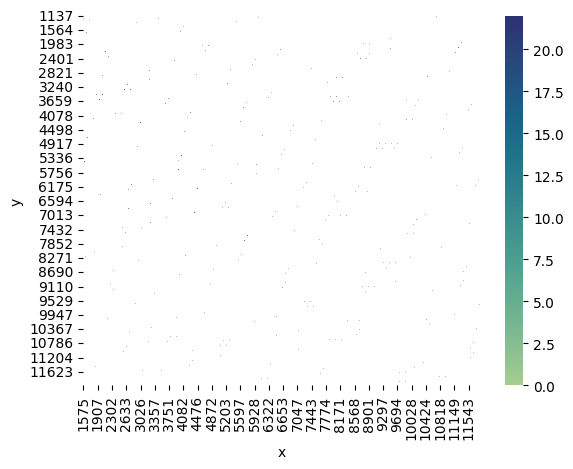

In [41]:
sns.heatmap(df, cmap='crest')

In [10]:
import seaborn as sns
import pandas as pd
import numpy as np


In [5]:
df = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [1, 2, 3, 4, 5], 'value': [10, 20, 30, 40, 50]})


In [6]:
df

,x,y,value
0,1,1,10
1,2,2,20
2,3,3,30
3,4,4,40
4,5,5,50


In [7]:
df = df.pivot(index='y', columns='x', values='value')


In [8]:
df

x,1,2,3,4,5
y,,,,,
1,10.0,NaN,NaN,NaN,NaN
2,NaN,20.0,NaN,NaN,NaN
3,NaN,NaN,30.0,NaN,NaN
4,NaN,NaN,NaN,40.0,NaN
5,NaN,NaN,NaN,NaN,50.0


<AxesSubplot: xlabel='x', ylabel='y'>

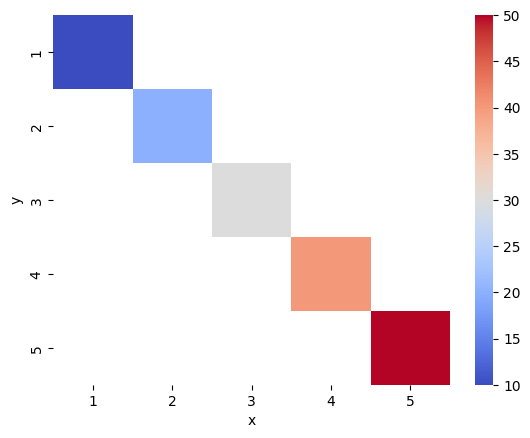

In [11]:
sns.heatmap(df, cmap='coolwarm')

In [5]:
locations_tmp, embeddings_tmp = load_cell_data()

In [17]:
locations_tmp['A1'][:10]

array([[4715,  453],
       [7906,  441],
       [1959,  700],
       [1980,  699],
       [1970,  733],
       [2159,  707],
       [2183,  719],
       [3139,  757],
       [3174,  741],
       [3248,  706]])

In [18]:
embeddings_tmp['A1'][0]

array([ 2.25678110e+00, -4.79955524e-01, -6.62872970e-01,  2.30033159e-01,
       -9.32560921e-01, -1.13081086e+00, -2.16766357e-01,  4.10521030e-01,
        3.15246642e-01,  5.40250987e-02,  1.86015415e+00, -7.58415997e-01,
       -9.50717568e-01,  2.45556760e+00,  1.38581359e+00,  2.11405843e-01,
        9.07454908e-01, -8.00827622e-01,  1.09718120e+00, -2.06002784e+00,
        2.42316175e+00, -4.53550935e-01,  9.36056376e-01, -1.04726565e+00,
       -3.17632444e-02, -6.90412760e-01,  7.35974967e-01, -2.23976874e+00,
       -8.47924873e-03,  3.18286657e+00,  4.49779183e-01,  6.92433953e-01,
       -5.82760692e-01, -2.21344137e+00, -4.38014388e-01, -9.01443362e-01,
       -3.38155448e-01,  5.09549618e-01, -2.94445539e+00,  7.78926253e-01,
       -6.35823086e-02, -2.81870842e+00,  1.27027667e+00, -1.44534659e+00,
       -4.59911346e-01, -5.30900478e-01, -2.96639681e-01,  1.43581223e+00,
       -5.11956215e-01, -2.02251613e-01,  5.47006577e-02, -3.28287780e-01,
        2.24140716e+00, -

In [2]:
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/store'
embedding_dir=f'{storeDir}/nodes'
basename = 'A1'
df = pickle.load(open(os.path.join(embedding_dir,f"{basename}.pickle"), "rb"))
emb = df.Embedding.values
pos = df[['X','Y']].values

In [3]:
df.head()

,X,Y,Embedding
0,4715,453,"[2.256781, -0.47995552, -0.66287297, 0.2300331..."
1,7906,441,"[2.22486, -0.47328785, -0.6473981, 0.21656379,..."
2,1959,700,"[2.3433554, -0.4971126, -0.7043746, 0.2669446,..."
3,1980,699,"[2.317294, -0.49464932, -0.6928296, 0.25558662..."
4,1970,733,"[2.3696814, -0.5104139, -0.72137594, 0.2766989..."


In [4]:
from DataManager import dataManager
dm = dataManager(['A1', 'B1', 'C1', 'D1'])

Loading Detections...


/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Fetching Expression...


/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [6]:
from graphgen import neighborFinder
datasets = []
avg = 0
n = neighborFinder(dm.detxy['A1'], tile_factor=100)

In [41]:
dm.detxy['A1'][3]

(1980, 699)

In [47]:
((1816-1784)**2 + (1173-1292)**2)**(1/2)

123.22743201089601

In [8]:
len(dm.detxy['A1'])

26193

In [12]:
n

In [46]:
dm.nodexy['A1'][3]

[1816, 1292]

In [18]:
n.find(dm.nodexy['A1'][3], 150)

[272, 273, 572, 277]

In [19]:
neighbors = n.find(dm.nodexy['A1'][3], 150)

In [30]:
spos, semb = [], []
for index in neighbors:
    spos.append(pos[index])
    semb.append(emb[index])

In [31]:
spos

[array([1784, 1173]),
 array([1751, 1207]),
 array([1826, 1287]),
 array([1951, 1235])]

In [32]:
semb[0].shape

(1000,)

In [33]:
len(semb)

4

In [34]:
semb = torch.tensor(np.stack([x for x in semb]), dtype=torch.float32)
spos = torch.tensor(np.array(spos), dtype=torch.float32)

In [36]:
semb.shape

torch.Size([4, 1000])

In [40]:
help(neighborFinder.find)

Help on function find in module graphgen:

find(self, pos, rad)



In [ ]:
sgraph = radius_graph(spos, r=graphrad, batch=None, loop=True)

In [ ]:
sgraph = sgraph.detach().cpu()
sgraph = torch_geometric.utils.add_remaining_self_loops(sgraph)[0]

In [58]:
# Creating the 3-hop neighborhood
# This only includes the indexes of the cells, the adjacency matrix can be
# constructed by selecting the relevant rows/columns of the main adj matrix

def create_neighborhood(adjacency_matrix, starting_indexes, hop_count):
    accessible = np.zeros(adjacency_matrix.shape[0], dtype=bool)
    accessible[starting_indexes] = True
    
    for hop in range(hop_count):
        accessible = accessible | (accessible @ adjacency_matrix)
        
    return np.where(accessible)[0]

def create_neighborhood_edge_list(edge_list, starting_indexes, hop_count):
    accessible = set(starting_indexes)
    
    for hop in range(hop_count):
        next_accessible = {*accessible}
        for accessible_index in accessible:
            next_accessible.update(edge_list[accessible_index])
            
        accessible = next_accessible
        
    return np.array([*sorted(accessible)])


In [97]:
# Small test

# 3 -> 2 -> 1 -> 0
adj = np.array([
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [0, 0, 1, 0],
])

edges = [np.where(adj[i])[0] for i in range(adj.shape[0])]

In [98]:
edges

[array([3]), array([0]), array([0, 1]), array([2])]

In [101]:
create_neighborhood_edge_list(edges, [2], hop_count = 1)

array([0, 1, 2])

In [68]:
for create_neighborhood_fn, graph in zip(
    [create_neighborhood, create_neighborhood_edge_list],
    [adj, edges]
):
    assert (create_neighborhood_fn(graph, [2], hop_count=4) == np.array([0, 1, 2])).all()
    assert (create_neighborhood_fn(graph, [2], hop_count=2) == np.array([0, 1, 2])).all()
    assert (create_neighborhood_fn(graph, [3], hop_count=2) == np.array([1, 2, 3])).all()
    assert (create_neighborhood_fn(graph, [3], hop_count=3) == np.array([0, 1, 2, 3])).all()
    assert (create_neighborhood_fn(graph, [3], hop_count=0) == np.array([3])).all()
    assert (create_neighborhood_fn(graph, [1], hop_count=1) == np.array([0, 1])).all()

In [76]:
create_neighborhood_fn(graph, [2], hop_count=4)

array([0, 1, 2])

In [4]:
(create_neighborhood_fn(graph, [2], hop_count=4) == np.array([0, 1, 2])).all()

True

In [5]:
create_neighborhood_fn(graph, [2], hop_count=4) 

array([0, 1, 2])

In [7]:
(create_neighborhood_fn(graph, [3], hop_count=3) == np.array([0, 1, 2, 3])).all()

True

In [96]:
create_neighborhood_fn(graph, [3], hop_count=2)

array([1, 2, 3])